In [3]:
# Replicate ITI results, make sure ITI utils and probing utils work right

#%%
from IPython import get_ipython

ipython = get_ipython()
# Code to automatically update the TransformerLens code as its edited without restarting the kernel
ipython.magic("load_ext autoreload")
ipython.magic("autoreload 2")
    
import plotly.io as pio
# pio.renderers.default = "png"
# Import stuff

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

from tqdm import tqdm
# from utils.probing_utils import ModelActs
from utils.dataset_utils import CounterFact_Dataset, TQA_MC_Dataset, EZ_Dataset

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

from utils.iti_utils import patch_iti

from utils.analytics_utils import plot_probe_accuracies, plot_norm_diffs, plot_cosine_sims
import os
from torch import Tensor

from utils.analytics_utils import plot_z_probe_accuracies, plot_resid_probe_accuracies
from utils.new_probing_utils import ModelActsLargeSimple, ChunkedModelActs
from plotly.subplots import make_subplots


/tmp/ipykernel_3125571/2503052483.py:8: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_3125571/2503052483.py:9: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


## Format raw activations

Format unformatted activation files with each prompt being a single file, into formatted activations of each component's collated acts.

Only has to be done once.

In [4]:
# N = 2550 #upper bound the global (level 0) index
d_head = 128
n_layers = 80
n_heads = 64
# num_params = "70b"

# reformat_acts_for_probing_fully_batched(run_id, N, d_head, n_layers, n_heads, "honest")
# reformat_acts_for_probing_fully_batched(run_id, N, d_head, n_layers, n_heads, "liar")
# reformat_acts_for_probing_fully_batched(run_id, N, d_head, n_layers, n_heads, "neutral")


## Initialize ModelActs objects. 

ModelActsLargeSimple is if we want to store all activations in memory at once (memory inefficient but faster transfer accuracy). 

ChunkedModelActs is if we don't want to keep activations in memory, instead load in activations in batches of layers and train probes iteratively, then unload activations. Transfer accuracy is much slower.

In [5]:
# datasets = ["azaria_mitchell_inventions", "azaria_mitchell_elements", "azaria_mitchell_animals", "azaria_mitchell_cities", "azaria_mitchell_facts", "azaria_mitchell_companies", "azaria_mitchell_capitals"]
datasets = ["azaria_mitchell_facts", "azaria_mitchell_companies"]
# datasets = datasets[:2]
modes = ["honest", "neutral", "liar"]
act_dict = {}
for dataset_name in datasets:
    act_dict[dataset_name] = {}
    for mode in modes:
        act_dict[dataset_name][mode]: ModelActsLargeSimple = ModelActsLargeSimple()



In [6]:
seq_pos = -1
act_type = "z"
# act_types = ["logits", "resid_mid", "z", "mlp_out"]
act_types = ["z", "logits"]
modes = ["honest", "liar"]
dont_include = None
data_folder = f"/mnt/ssd-2/jamescampbell4"
run_id = 5

for dataset_name in tqdm(datasets):
    for mode in modes:
        print(f"Loading activations from {mode} model on {dataset_name}")
        for act_type in act_types:
            file_prefix = f"{data_folder}/activations/formatted/run_{run_id}_{mode}"
            if seq_pos is not None:
                file_prefix += f"_{seq_pos}"
            file_prefix += f"_{act_type}"
            if dataset_name is not None:
                file_prefix += f"_{dataset_name}"

            with open(f"{data_folder}/activations/formatted/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
                labels = torch.load(handle)
                # print(f"{labels.shape=}")
            # print(labels)
            
            act_dict[dataset_name][mode].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=dont_include, act_type=act_type, verbose=False)

            if act_type != "logits":
                act_dict[dataset_name][mode].train_probes(act_type, verbose=False, max_iter=10000)
        # elem_acts[label].load_acts_per_layer(f"data/large_run_1/activations/formatted/large_run_1_{label}", n_layers, n_heads, labels, exclude_points=dont_include)
    print(f"{dataset_name} dataset Size: {labels.shape[0]}")

  0%|          | 0/2 [00:00<?, ?it/s]

Loading activations from honest model on azaria_mitchell_facts
Loading activations from liar model on azaria_mitchell_facts


 50%|█████     | 1/2 [01:01<01:01, 61.02s/it]

azaria_mitchell_facts dataset Size: 599
Loading activations from honest model on azaria_mitchell_companies
Loading activations from liar model on azaria_mitchell_companies


100%|██████████| 2/2 [02:35<00:00, 77.55s/it]

azaria_mitchell_companies dataset Size: 1200


In [7]:
from transformers import LlamaTokenizer

weights_dir = f"{os.getcwd()}/llama-weights-70b"
tokenizer: LlamaTokenizer = LlamaTokenizer.from_pretrained(weights_dir)

In [8]:
import resource
print(f"Memory used: {resource.getrusage(resource.RUSAGE_SELF).ru_maxrss * 1e-6} GB") # check memory usage in GB

Memory used: 10.606219999999999 GB


In [9]:
def acc_tensor_from_dict(probe_accs_dict, n_layers, n_heads=None):
    """
    Helper method to convert dictionaries with component indices as keys (e.g. (5, 4) for Z dict or 79 for resid dict) to tensors, of shape (n_layers, n_heads) for Z or just (n_layers) for resid.
    """
    if n_heads is not None:
        probe_accs = np.zeros(shape=(n_layers, n_heads))
        for layer in range(n_layers):
            for head in range(n_heads):
                probe_accs[layer, head] = probe_accs_dict[(layer, head)]

    else:
        probe_accs = np.zeros(shape=(n_layers,))
        for layer in range(n_layers):
            probe_accs[layer] = probe_accs_dict[layer]
    return probe_accs


def get_px_fig(act_type, transfer_accs, n_layers, n_heads, title, graph_type=None):
    """
    Helper method to generate a figure showing a quantity (accuracy, cosine sim, whatever) for each layer of a model. If act_type is 
    args:
        act_type: "z" is treated alone, all others are 
    """
    if act_type == "z":
        px_fig = plot_z_probe_accuracies(transfer_accs, n_layers, n_heads=n_heads, title=title)
    else:
        px_fig = plot_resid_probe_accuracies(transfer_accs, n_layers, title=title, graph_type=graph_type)
    return px_fig

## Want to try transferring to harmful dataset activations
Model shouldn't be responding to these activations

In [10]:
# Format logits from harmful dataset
# dataset_name = "harmful"
# data_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}"
# n_acts = 1352

# for mode in ["honest", "liar"]:
#     logits = []
#     for data_index in range(n_acts):
#         with open(f"{data_folder}/inference_outputs/logits_{run_id}_{mode}_{data_index}.pt", "rb") as handle:
#             logits.append(torch.load(handle))
#     logits = torch.cat(logits, dim=0)
#     with open(f"{data_folder}/activations/formatted/run_{run_id}_{mode}_{seq_pos}_logits_{dataset_name}.pt", "wb") as handle:
#         torch.save(logits, handle)

In [11]:
# Load in Harmful Dataset
harmful_act_dict = {}
act_types = ["z", "logits"]
dataset_name = "harmful"
dont_include = None
run_id = 9
data_folder = f"/mnt/ssd-2/jamescampbell3/data/large_run_{run_id}"
modes = ["honest", "liar"]

for mode in tqdm(modes):
    harmful_act_dict[mode] = ModelActsLargeSimple()
    for act_type in act_types:
        file_prefix = f"{data_folder}/activations/formatted/run_{run_id}_{mode}"
        if seq_pos is not None:
            file_prefix += f"_{seq_pos}"
        file_prefix += f"_{act_type}"
        if dataset_name is not None:
            file_prefix += f"_{dataset_name}"

        with open(f"{data_folder}/activations/formatted/labels_{run_id}_{mode}_{seq_pos}_z_{dataset_name}.pt", "rb") as handle:
            labels = torch.load(handle)
            # print(f"{labels.shape=}")
        # print(labels)
        true_indices = torch.where(labels != 0)[0]
        false_indices = torch.where(labels == 0)[0]
        labels = labels[true_indices]
        # print(labels)

        harmful_act_dict[mode].load_acts(file_prefix, n_layers, n_heads=n_heads, labels=labels, exclude_points=false_indices, act_type=act_type)

100%|██████████| 2/2 [01:08<00:00, 34.27s/it]


In [12]:
# Inference Accuracy
mode = "liar"
scale_relative = False
harmful_accuracy = harmful_act_dict[mode].get_inference_accuracy(tokenizer, scale_relative=scale_relative)
print(f"{mode} model respÍonds to harmful prompts accurately {harmful_accuracy[0].mean()*100}%, inaccurately {harmful_accuracy[1].mean()*100}%")

liar model respÍonds to harmful prompts accurately 14.221946895122528%, inaccurately 34.90790128707886%


In [13]:
# Inference Accuracy
print(act_dict["azaria_mitchell_facts"]["honest"].get_inference_accuracy(tokenizer, scale_relative=True)[0].mean())
print(act_dict["azaria_mitchell_facts"]["honest"].get_inference_accuracy(tokenizer, scale_relative=True)[1].mean())


0.87612695
0.12387302


In [14]:
harmful_transfer_acc_tensors = np.zeros((len(datasets), len(modes), len(modes), n_layers, n_heads))

act_type = "z"

for dataset_idx1, dataset_name in enumerate(datasets):
    for idx1, mode in enumerate(modes):
        for idx2, other_mode in enumerate(modes):
            print(f"Computing transfer accs for {dataset_name} {mode} -> harmful {other_mode}")
            harmful_transfer_accs = {}
            for probe_index in act_dict[dataset_name][mode].probes[act_type]:
                harmful_transfer_accs[probe_index] = act_dict[dataset_name][mode].get_probe_transfer_acc(act_type, probe_index, harmful_act_dict[other_mode], test_only=False)
                # harmful_transfer_accs[probe_index] = act_dict[dataset_name][mode].get_probe_transfer_acc(act_type, probe_index, act_dict["azaria_mitchell_companies"][other_mode], test_only=False)
            if act_type == "z":
                harmful_transfer_acc_tensors[dataset_idx1, idx1, idx2] = acc_tensor_from_dict(harmful_transfer_accs, n_layers, n_heads)

Computing transfer accs for azaria_mitchell_facts honest -> harmful honest
Computing transfer accs for azaria_mitchell_facts honest -> harmful liar
Computing transfer accs for azaria_mitchell_facts liar -> harmful honest
Computing transfer accs for azaria_mitchell_facts liar -> harmful liar
Computing transfer accs for azaria_mitchell_companies honest -> harmful honest
Computing transfer accs for azaria_mitchell_companies honest -> harmful liar
Computing transfer accs for azaria_mitchell_companies liar -> harmful honest
Computing transfer accs for azaria_mitchell_companies liar -> harmful liar


In [16]:
def get_px_fig(act_type, transfer_accs, n_layers, n_heads, title, graph_type=None):
    """
    Helper method to generate a figure showing a quantity (accuracy, cosine sim, whatever) for each layer of a model. If act_type is 
    args:
        act_type: "z" is treated alone, all others are 
    """
    if act_type == "z":
        px_fig = plot_z_probe_accuracies(transfer_accs, n_layers, n_heads=n_heads, title=title)
    else:
        px_fig = plot_resid_probe_accuracies(transfer_accs, n_layers, title=title, graph_type=graph_type)
    return px_fig


fig = make_subplots(rows=len(modes), cols=len(modes))
for idx1, mode in enumerate(modes, start=1):
    for idx2, other_mode in enumerate(modes, start=1):
        transfer_accs = harmful_transfer_acc_tensors[0, idx1-1, idx2-1] # azaria_mitchell_facts -> harmful
        
        px_fig = get_px_fig(act_type, transfer_accs, n_layers, n_heads, title = f"Harmful Transfer Probe Accuracies, {act_type} Probes from {mode} tested on {other_mode}")

        fig.add_trace(
            px_fig['data'][0],  # add the trace from plotly express figure
            row=idx1,
            col=idx2
        )

for idx1 in range(1, len(modes)+1):
    fig.update_xaxes(title_text=f"Tested on harmful {modes[idx1-1]}", row=2, col=idx1)

for idx2 in range(1, len(modes)+1):
    fig.update_yaxes(title_text=f"Trained on Azaria Mitchell Facts {modes[idx2-1]}", row=idx2, col=1)

# fig.update_layout(title_text=f"Transfer {act_type} Probe Accuracies, Dataset Azaria Mitchell Facts to Harmful", height=1000)
fig.update_layout(title_text=f"Transfer {act_type} Probe Accuracies, Dataset Azaria Mitchell Facts to Harmful", height=1000)
fig.show()
    

In [39]:
# Inference Accuracy on Harmful



## Back to old transfer code

In [28]:
act_type = "resid_mid"
if act_type == "z":
    transfer_acc_tensors = np.zeros(shape=(len(datasets), len(datasets), len(modes), len(modes), n_layers, n_heads))
else:
    transfer_acc_tensors = np.zeros(shape=(len(datasets), len(datasets), len(modes), len(modes), n_layers))

with tqdm(total=len(datasets)**2) as pbar:
    for dataset_idx1, dataset_name in enumerate(datasets):
        for dataset_idx2, other_dataset_name in enumerate(datasets):
            for idx1, mode in enumerate(modes):
                for idx2, other_mode in enumerate(modes):
                    transfer_accs = {}
                    for probe_index in act_dict[dataset_name][mode].probes[act_type]:
                        transfer_accs[probe_index] = act_dict[dataset_name][mode].get_probe_transfer_acc(act_type, probe_index, act_dict[other_dataset_name][other_mode])
                    
                    if act_type == "z":
                        transfer_acc_tensors[dataset_idx1, dataset_idx2, idx1, idx2] = acc_tensor_from_dict(transfer_accs, n_layers, n_heads)
                    else:
                        transfer_acc_tensors[dataset_idx1, dataset_idx2, idx1, idx2] = acc_tensor_from_dict(transfer_accs, n_layers)

            pbar.update(1)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [06:50<00:00,  8.37s/it]


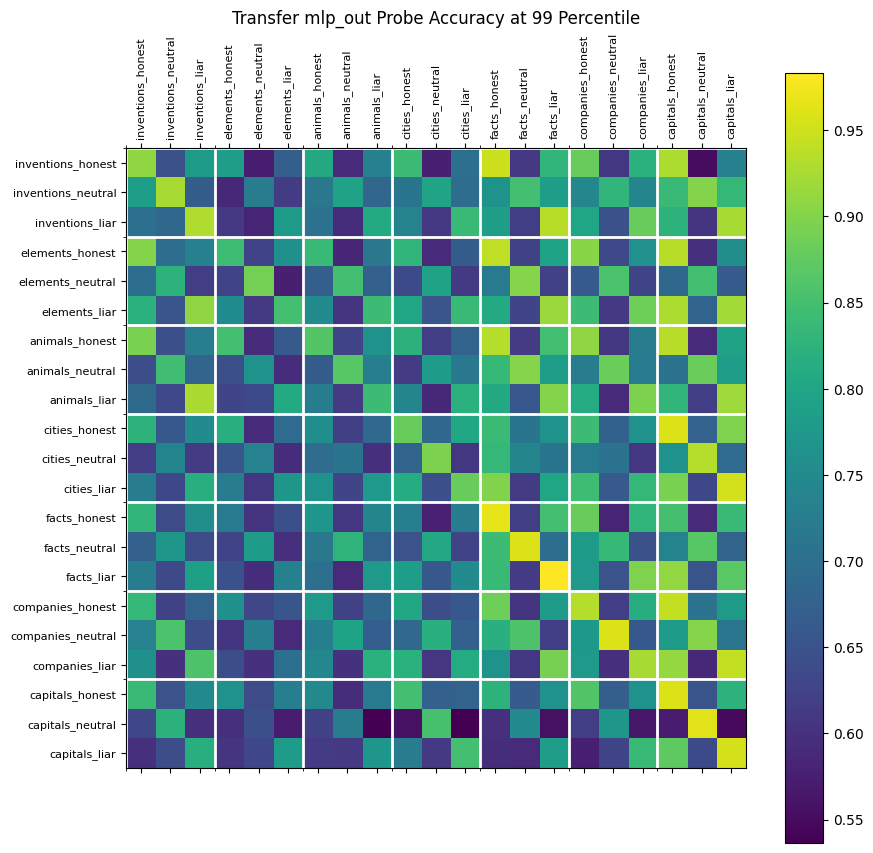

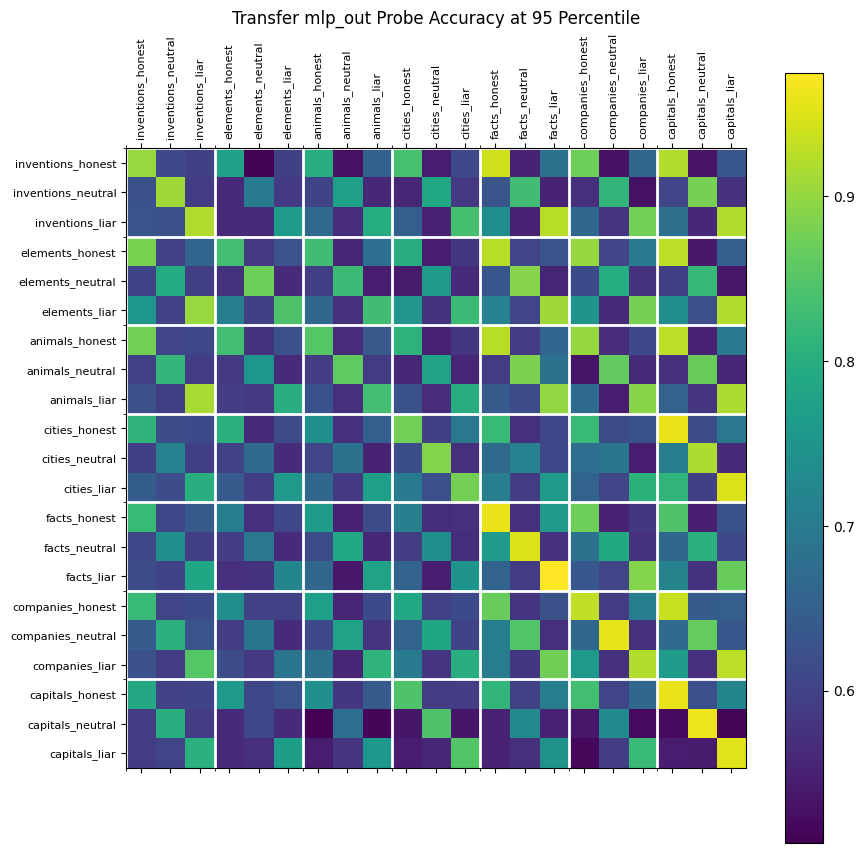

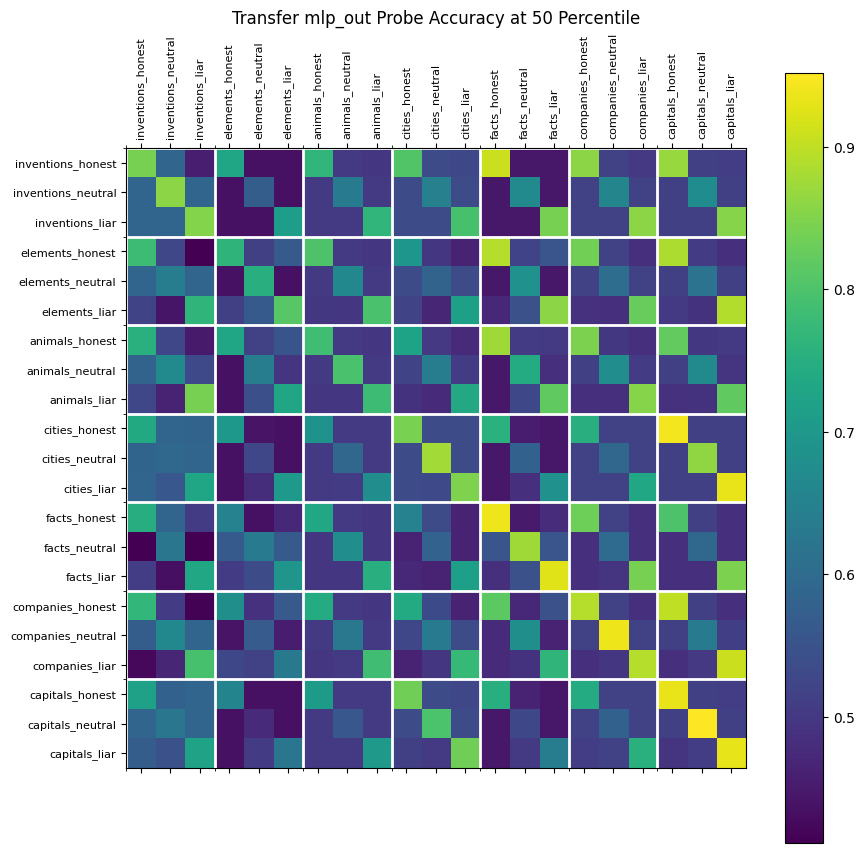

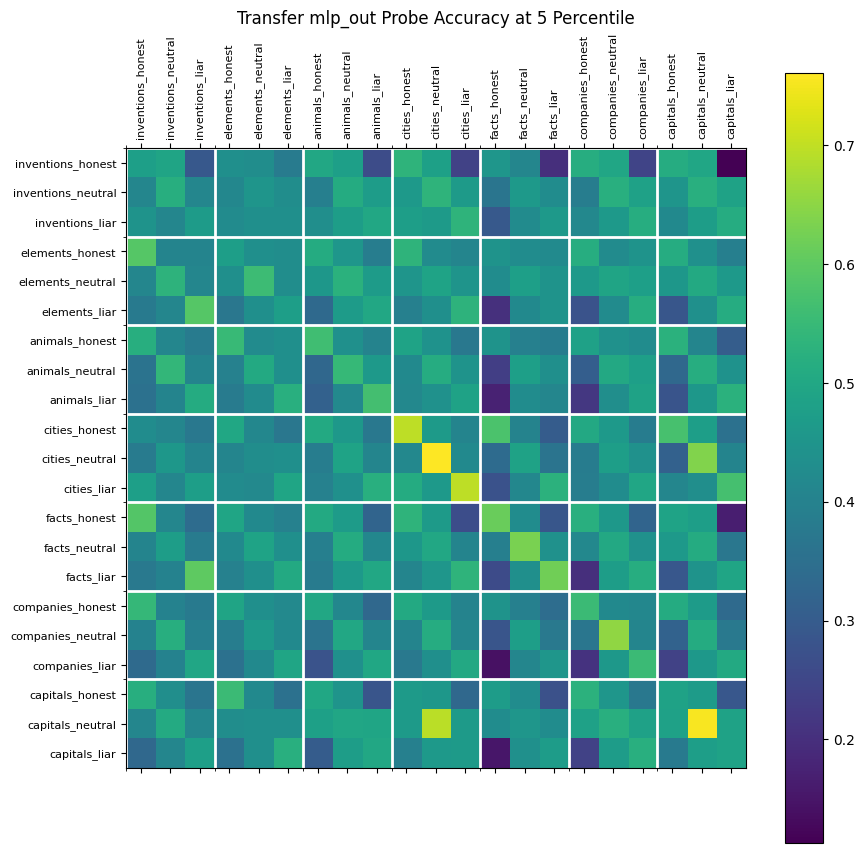

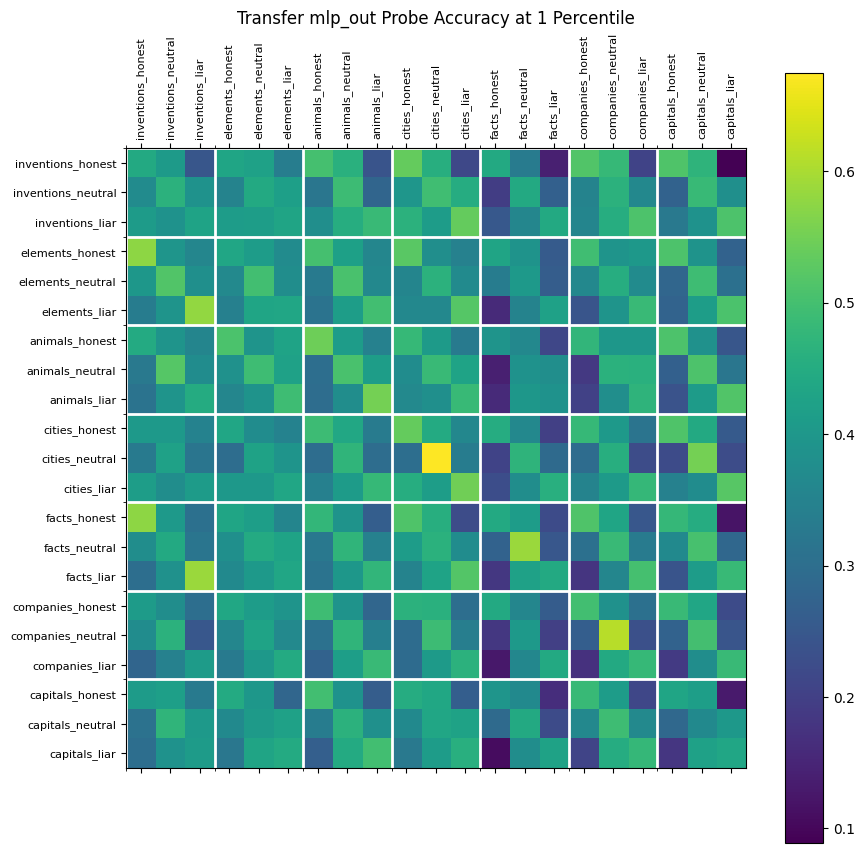

In [29]:
import matplotlib.pyplot as plt
if act_type == "z":
    flattened_accs = einops.rearrange(transfer_acc_tensors, "d_1 d_2 m_1 m_2 n_l n_h -> (d_1 m_1) (d_2 m_2) (n_l n_h)")
else:
    flattened_accs = einops.rearrange(transfer_acc_tensors, "d_1 d_2 m_1 m_2 n_l -> (d_1 m_1) (d_2 m_2) n_l")

percentiles = [99, 95, 50, 5, 1]
for percentile in percentiles:
    acc_values = np.percentile(flattened_accs, percentile, axis=2)
    expanded_labels = [f"{dataset[16:]}_{mode}" for dataset in datasets for mode in modes]

    fig, ax = plt.subplots(figsize=(10,10))

    # Displaying the tensor values as colors
    cax = ax.matshow(acc_values, cmap="viridis")

    # Setting x and y ticks for major
    ax.set_xticks(np.arange(0, len(datasets)*len(modes), 1))
    ax.set_yticks(np.arange(0, len(datasets)*len(modes), 1))

    # Setting x and y ticks for minor
    ax.set_xticks(np.arange(-0.5, len(datasets)*len(modes) - .5, len(modes)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(datasets)*len(modes) - .5, len(modes)), minor=True)

    # Set the tick labels
    ax.set_xticklabels(expanded_labels, rotation=90, fontsize=8, minor=False)
    ax.set_yticklabels(expanded_labels, fontsize=8, minor=False)

    # Grid lines
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)

    # Colorbar for reference
    plt.colorbar(cax)

    plt.title(f"Transfer {act_type} Probe Accuracy at {percentile} Percentile")
    plt.show()

# Cosine Similarities of probe weights between ModelActs

In [38]:
act_type = "z"
if act_type == "z":
    cosine_similarity_tensors = np.zeros(shape=(len(datasets), len(datasets), len(modes), len(modes), n_layers, n_heads))
else:
    cosine_similarity_tensors = np.zeros(shape=(len(datasets), len(datasets), len(modes), len(modes), n_layers))

with tqdm(total=len(datasets)**2) as pbar:
    for dataset_idx1, dataset_name in enumerate(datasets):
        for dataset_idx2, other_dataset_name in enumerate(datasets):
            for idx1, mode in enumerate(modes):
                for idx2, other_mode in enumerate(modes):
                    cos_sims = {}
                    for probe_index in act_dict[dataset_name][mode].probes[act_type]:
                        coefs_1 = act_dict[dataset_name][mode].probes[act_type] [probe_index].coef_.squeeze()
                        coefs_2 = act_dict[other_dataset_name][other_mode].probes[act_type] [probe_index].coef_.squeeze()
                        cos_sims[probe_index] = np.dot(coefs_1, coefs_2)/(np.linalg.norm(coefs_1)*np.linalg.norm(coefs_2))
                    
                    if act_type == "z":
                        cosine_similarity_tensors[dataset_idx1, dataset_idx2, idx1, idx2] = acc_tensor_from_dict(cos_sims, n_layers, n_heads)
                    else:
                        cosine_similarity_tensors[dataset_idx1, dataset_idx2, idx1, idx2] = acc_tensor_from_dict(cos_sims, n_layers)

            pbar.update(1)

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:16<00:00,  2.89it/s]


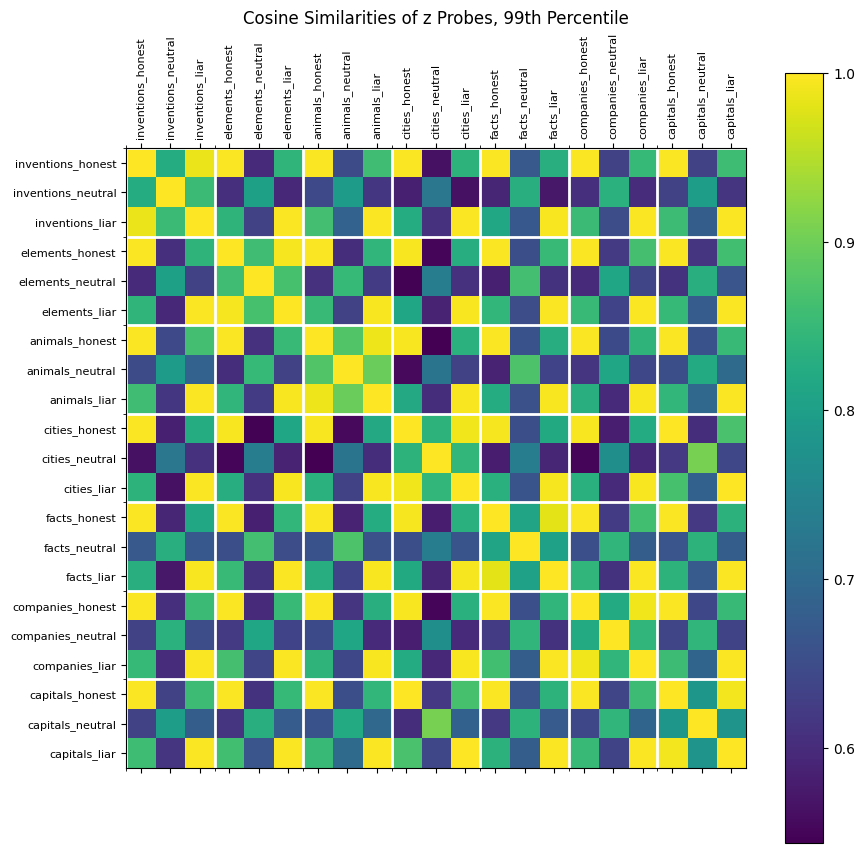

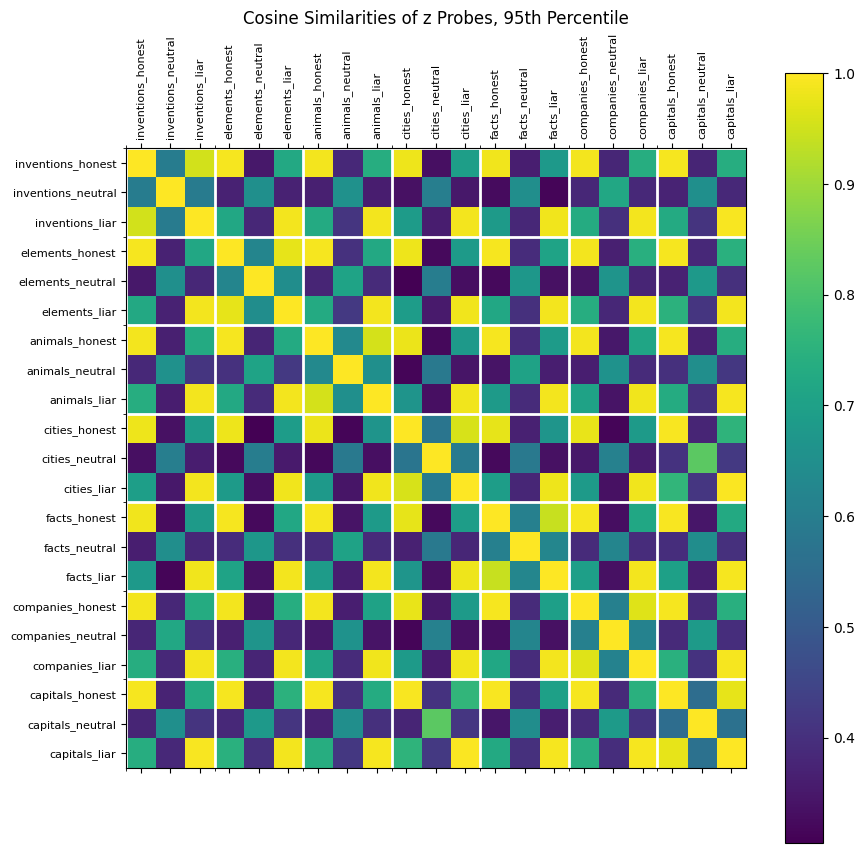

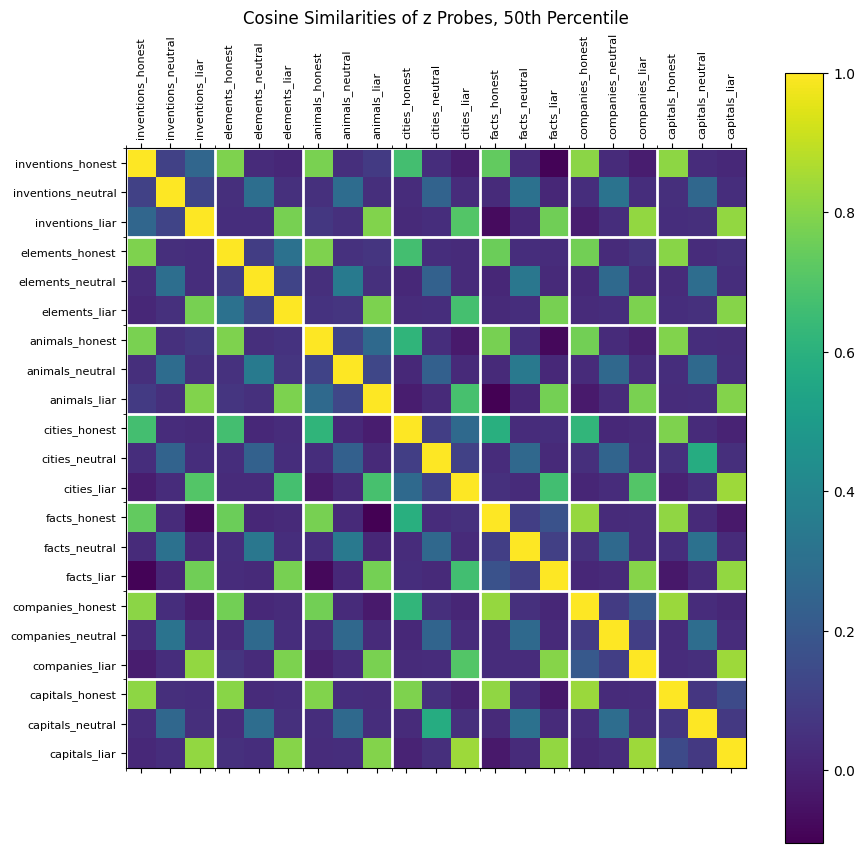

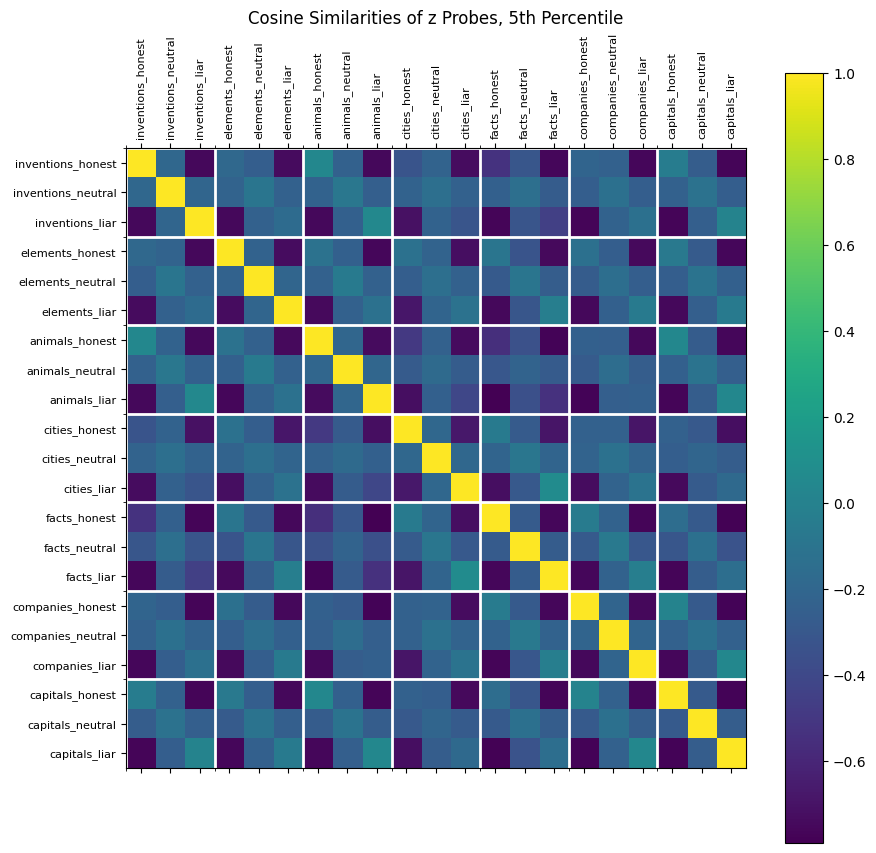

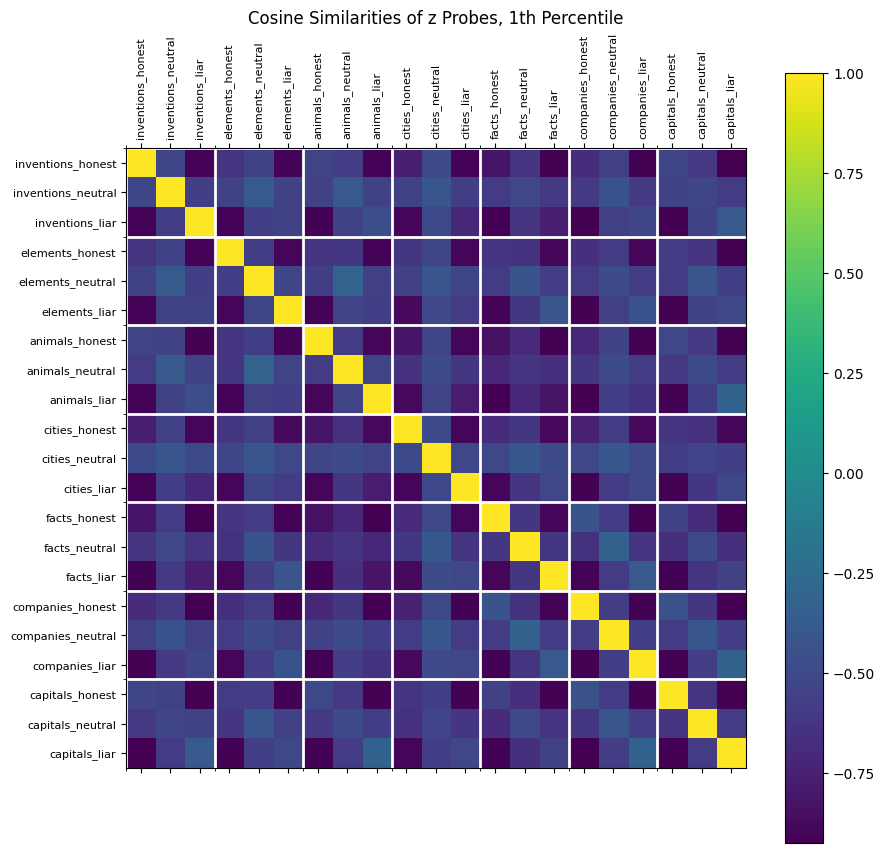

In [39]:
import matplotlib.pyplot as plt
if act_type == "z":
    flattened_cos_sims = einops.rearrange(cosine_similarity_tensors, "d_1 d_2 m_1 m_2 n_l n_h -> (d_1 m_1) (d_2 m_2) (n_l n_h)")
else:
    flattened_cos_sims = einops.rearrange(cosine_similarity_tensors, "d_1 d_2 m_1 m_2 n_l -> (d_1 m_1) (d_2 m_2) n_l")

percentiles = [99, 95, 50, 5, 1]
for percentile in percentiles:
    acc_values = np.percentile(flattened_cos_sims, percentile, axis=2)
    expanded_labels = [f"{dataset[16:]}_{mode}" for dataset in datasets for mode in modes]

    fig, ax = plt.subplots(figsize=(10,10))

    # Displaying the tensor values as colors
    cax = ax.matshow(acc_values, cmap="viridis")

    # Setting x and y ticks for major
    ax.set_xticks(np.arange(0, len(datasets)*len(modes), 1))
    ax.set_yticks(np.arange(0, len(datasets)*len(modes), 1))

    # Setting x and y ticks for minor
    ax.set_xticks(np.arange(-0.5, len(datasets)*len(modes) - .5, len(modes)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(datasets)*len(modes) - .5, len(modes)), minor=True)

    # Set the tick labels
    ax.set_xticklabels(expanded_labels, rotation=90, fontsize=8, minor=False)
    ax.set_yticklabels(expanded_labels, fontsize=8, minor=False)

    # Grid lines
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)

    # Colorbar for reference
    plt.colorbar(cax)

    plt.title(f"Cosine Similarities of {act_type} Probes, {percentile}th Percentile")
    plt.show()

## Analyze Probe Accuracy vs Inference Accuracy
Make plot of probe accuracies vs inference accuracy

In [61]:
# Get indices of rows of each dataset in the big dataset
from datasets import load_dataset
dataset_name = "notrichardren/truthfulness_high_quality"
dataset = load_dataset(dataset_name)

#get the rows that have azaria_mitchell_facts as their value for the dataset column
dataset_indices = {dataset_name: [row['ind'] for row in dataset["combined"] if row['dataset'] == dataset_name] for dataset_name in tqdm(datasets)}

100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


In [16]:
# Format logits into formatted style: run_{run_id}_{mode}_{seq_pos}_logits_{dataset_name}.pt
seq_pos = -1
for dataset_name in tqdm(datasets):
    
    for mode in ["honest", "liar"]:
        logits = []
        for data_index in dataset_indices[dataset_name]:
            with open(f"activations/inference_outputs/logits_{run_id}_{mode}_{data_index}.pt", "rb") as handle:
                logits.append(torch.load(handle))
        logits = torch.cat(logits, dim=0)
        with open(f"activations/formatted/run_{run_id}_{mode}_{seq_pos}_logits_{dataset_name}.pt", "wb") as handle:
            torch.save(logits, handle)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:09<00:00,  1.39s/it]


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:03<00:00,  2.13it/s]


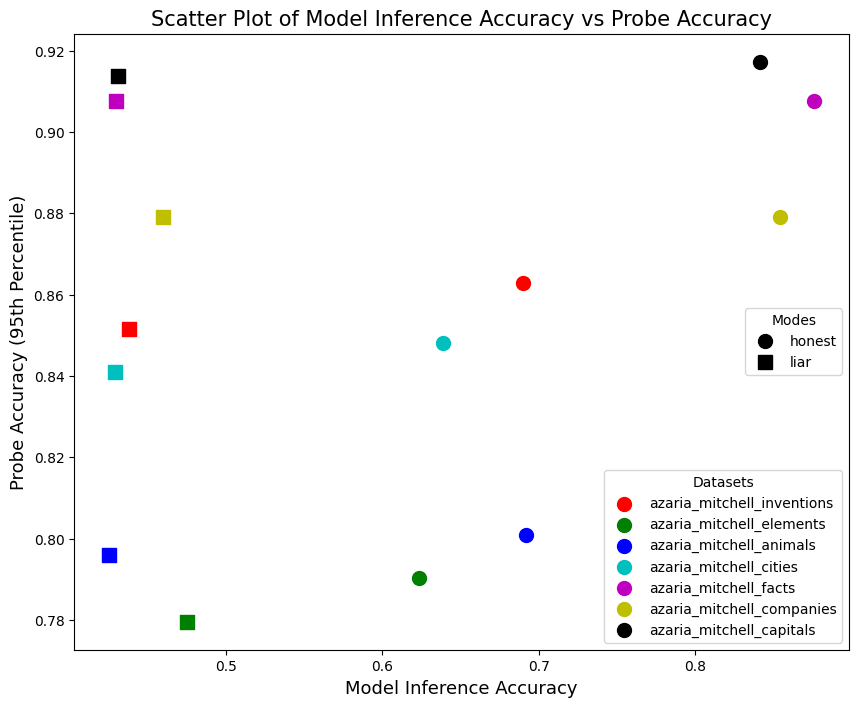

In [78]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

act_type = "z"

# Initialize plot
plt.figure(figsize=(10, 8))

# Define a color map
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
markers = ['o', 's']

dataset_legend_handles = []

for dataset_idx, dataset_name in enumerate(tqdm(datasets)):
    for mode_idx, mode in enumerate(modes):
        correct_probs, incorrect_probs = act_dict[dataset_name][mode].get_inference_accuracy(tokenizer, scale_relative=True)
        
        correct_prob = np.mean(correct_probs)
        probe_accs = acc_tensor_from_dict(act_dict[dataset_name][mode].probe_accs[act_type], n_layers=n_layers, n_heads=n_heads)
        probe_acc = np.percentile(probe_accs, 95)
        sc = plt.scatter(correct_prob, probe_acc, color=colors[dataset_idx], label=f"{dataset_name}-{mode}", marker=markers[mode_idx], s=100)

        if mode_idx == 0:
            dataset_legend_handles.append(sc)

mode_legend_handles = []
for marker in markers:
    mode_legend_handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markersize=10))


plt.xlabel("Model Inference Accuracy", fontsize=13)
plt.ylabel("Probe Accuracy (95th Percentile)", fontsize=13)
plt.title("Scatter Plot of Model Inference Accuracy vs Probe Accuracy", fontsize=15)

# Add legend using only the handles we've collected
first_legend = plt.legend(dataset_legend_handles, datasets, title='Datasets', loc='lower right')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

plt.legend(mode_legend_handles, modes, title="Modes", loc="center right")
plt.show()